Install Packages

In [ ]:
!pip install numpy scipy scikit-learn matplotlib

Synthetic Data with Anomalies

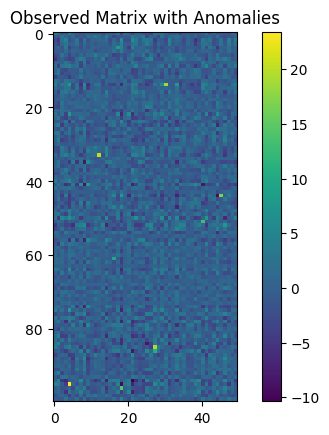

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def generate_data(n_samples=100, n_features=50, n_outliers=10):
    np.random.seed(42)
    # Low-rank component
    L_true = np.dot(np.random.randn(n_samples, 5), np.random.randn(5, n_features))

    # Sparse anomaly matrix
    S_true = np.zeros_like(L_true)
    idx = np.random.choice(np.arange(L_true.size), n_outliers, replace=False)
    S_true.flat[idx] = np.random.uniform(10, 20, size=n_outliers)

    # Observed data
    X = L_true + S_true
    return X, L_true, S_true

X, L_true, S_true = generate_data()
plt.imshow(X, cmap='viridis')
plt.title("Observed Matrix with Anomalies")
plt.colorbar()
plt.show()

Robust Principal Component Analysis (RPCA) Optimization via Alternating Direction Method of Multipliers (ADMM)

In [ ]:
from numpy.linalg import svd
from scipy.sparse.linalg import svds

def shrinkage(X, tau):
    return np.sign(X) * np.maximum(np.abs(X) - tau, 0)

def svd_threshold(X, tau):
    U, S, VT = svd(X, full_matrices=False)
    S_thresh = shrinkage(S, tau)
    return U @ np.diag(S_thresh) @ VT

def rpca_admm(X, lambda_=None, mu=1.0, tol=1e-7, max_iter=1000):
    m, n = X.shape
    if lambda_ is None:
        lambda_ = 1 / np.sqrt(max(m, n))

    L = np.zeros((m, n))
    S = np.zeros((m, n))
    Y = np.zeros((m, n))

    for i in range(max_iter):
        # Low-rank update via SVD shrinkage
        L = svd_threshold(X - S + (1/mu)*Y, 1/mu)

        # Sparse update via soft-thresholding
        S = shrinkage(X - L + (1/mu)*Y, lambda_/mu)

        # Dual variable update
        Z = X - L - S
        Y += mu * Z

        # Convergence check
        if np.linalg.norm(Z, ord='fro') / np.linalg.norm(X, ord='fro') < tol:
            break

    return L, S


Run RPCA and Visualize the Decomposition

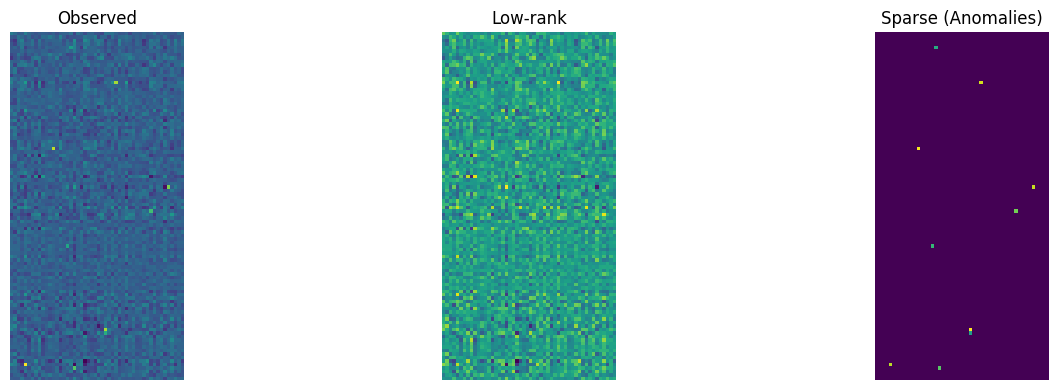

In [ ]:
L_hat, S_hat = rpca_admm(X)

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
axes[0].imshow(X, cmap='viridis'); axes[0].set_title("Observed")
axes[1].imshow(L_hat, cmap='viridis'); axes[1].set_title("Low-rank")
axes[2].imshow(S_hat, cmap='viridis'); axes[2].set_title("Sparse (Anomalies)")
for ax in axes: ax.axis('off')
plt.tight_layout()
plt.show()

Analyze Singular Values of Low-Rank Matrix

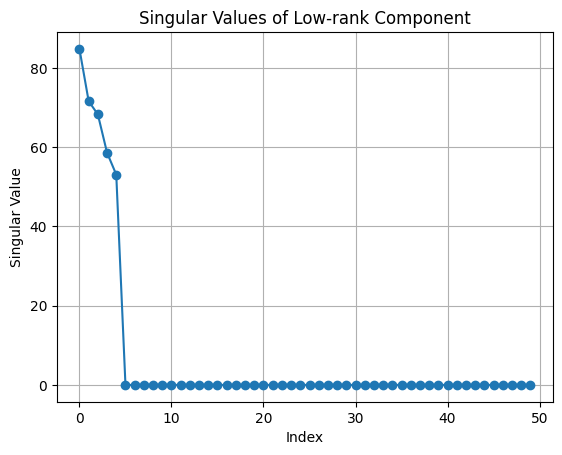

In [ ]:
U, S_vals, VT = svd(L_hat)
plt.plot(S_vals, 'o-')
plt.title("Singular Values of Low-rank Component")
plt.xlabel("Index")
plt.ylabel("Singular Value")
plt.grid(True)
plt.show()

Detect Anomalies Using Mahalanobis Distance

In [ ]:
from sklearn.covariance import EmpiricalCovariance
from scipy.stats import chi2

def detect_anomalies(S, alpha=0.99):
    # Flatten and filter non-zero values
    anomalies = np.argwhere(np.abs(S) > 1e-3)

    # Mahalanobis distance
    flat_S = S.reshape(S.shape[0], -1)
    cov = EmpiricalCovariance().fit(flat_S)
    dist = cov.mahalanobis(flat_S)
    threshold = chi2.ppf(alpha, df=flat_S.shape[1])             # RIP Diogo Jota

    anomaly_indices = np.where(dist > threshold)[0]
    return anomaly_indices, dist, threshold

anomalous_rows, dist, thresh = detect_anomalies(S_hat)
print(f"Detected anomalous row indices: {anomalous_rows}")

Detected anomalous row indices: [ 4 14 33 44 51 61 95 96]


Load Real Traffic Data -  log-style traffic, each row is a timestamped feature vector of aggregated stats (bytes sent, packets, TCP flags)

In [ ]:
import pandas as pd
import numpy as np

# Simulated traffic: 500 time intervals, 6 features per interval
# Typical features: [total_packets, total_bytes, flows, syn_count, ack_count, dst_ports]
np.random.seed(0)
normal_traffic = np.random.normal(loc=100, scale=10, size=(500, 6))

# Inject anomalies (sudden spikes)
anomaly_indices = np.random.choice(500, size=10, replace=False)
anomaly_matrix = np.zeros_like(normal_traffic)
anomaly_matrix[anomaly_indices] = np.random.uniform(300, 500, size=(10, 6))

traffic_matrix = normal_traffic + anomaly_matrix

# Convert to DataFrame
columns = ["packets", "bytes", "flows", "syn", "ack", "dst_ports"]
df_traffic = pd.DataFrame(traffic_matrix, columns=columns)
df_traffic["timestamp"] = pd.date_range("2023-01-01", periods=500, freq="T")
df_traffic.set_index("timestamp", inplace=True)
df_traffic.head()


/tmp/ipython-input-13-4158616892.py:19: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_traffic["timestamp"] = pd.date_range("2023-01-01", periods=500, freq="T")


,packets,bytes,flows,syn,ack,dst_ports
timestamp,,,,,,
2023-01-01 00:00:00,117.640523,104.001572,109.787380,122.408932,118.675580,90.227221
2023-01-01 00:01:00,109.500884,98.486428,98.967811,104.105985,101.440436,114.542735
2023-01-01 00:02:00,107.610377,101.216750,104.438632,103.336743,114.940791,97.948417
2023-01-01 00:03:00,103.130677,91.459043,74.470102,106.536186,108.644362,92.578350
2023-01-01 00:04:00,490.264128,477.985645,469.761506,458.245040,587.574827,583.726344


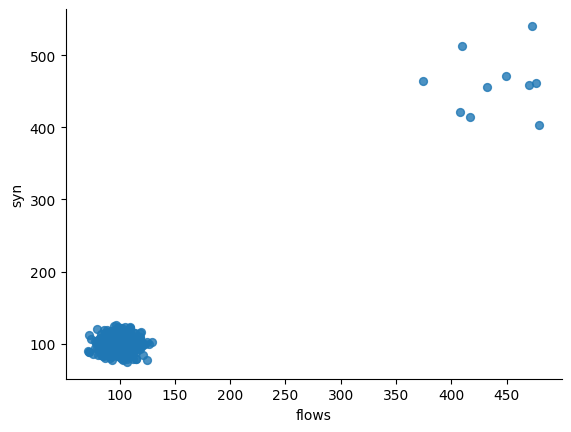

In [ ]:
# @title flows vs syn

from matplotlib import pyplot as plt
df_traffic.plot(kind='scatter', x='flows', y='syn', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

Apply RPCA on the Traffic Matrix

In [ ]:
L_hat, S_hat = rpca_admm(df_traffic.values)

Visualize Decomposition

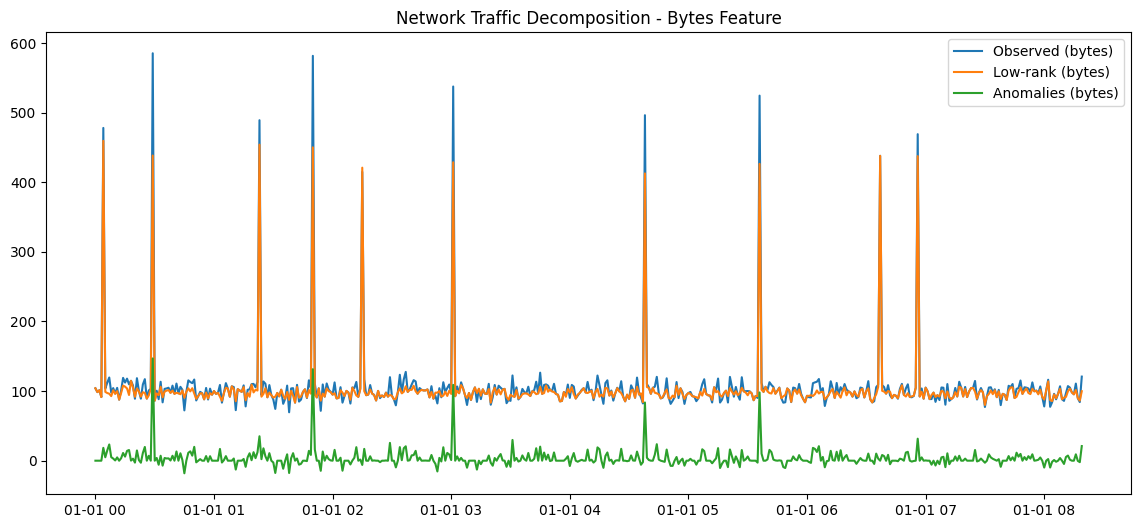

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(df_traffic.index, df_traffic["bytes"], label="Observed (bytes)")
plt.plot(df_traffic.index, L_hat[:, 1], label="Low-rank (bytes)")
plt.plot(df_traffic.index, S_hat[:, 1], label="Anomalies (bytes)")
plt.legend()
plt.title("Network Traffic Decomposition - Bytes Feature")
plt.show()

Anomaly Detection

In [ ]:
anomalous_rows = np.where(np.abs(S_hat).max(axis=1) > 50)[0]
anomaly_timestamps = df_traffic.index[anomalous_rows]

print("Anomalous Time Windows Detected:")
print(anomaly_timestamps)

Anomalous Time Windows Detected:
DatetimeIndex(['2023-01-01 00:04:00', '2023-01-01 00:29:00',
               '2023-01-01 01:23:00', '2023-01-01 01:50:00',
               '2023-01-01 02:15:00', '2023-01-01 03:01:00',
               '2023-01-01 04:38:00', '2023-01-01 05:36:00',
               '2023-01-01 06:37:00', '2023-01-01 06:56:00'],
              dtype='datetime64[ns]', name='timestamp', freq=None)
